In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pyfusion.data import load

In [2]:
SLICE = 70
WINDOW_X = 45
WINDOW_Y = 105

KERNEL_SIZE = 3
NOISE_SCALE = 0.2   # sigma
INTEGRATION_SCALE = 10   # rho
ALPHA = 0.001

ITERATIONS = 10_000
STEP_SIZE = 3

In [3]:
def gaussian(std_dev: float, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Generate a Gaussian kernel.
    """
    return np.exp(-(x**2 + y**2) / (2 * std_dev**2)) / (2 * np.pi * std_dev**2)


def dx_gaussian(std_dev: float, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Compute the derivative of a Gaussian kernel with respect to x.
    """
    return -x * gaussian(std_dev, x, y) / (std_dev**2)


def dy_gaussian(std_dev: float, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Compute the derivative of a Gaussian kernel with respect to y.
    """
    return -y * gaussian(std_dev, x, y) / (std_dev**2)

def lambda_func(mu_1, mu_2):
    """
    Compute the second eigenvalue based on the first eigenvalue and the second mean, if mu_1 and mu_2 are not close.
    """
    return ALPHA + (1-ALPHA) * np.exp(-1/(mu_1 - mu_2)**2)

In [4]:
#type: ignore
def plot(data, title=None):
    """
    Plot the data with optional title and axis labels.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap="gray")
    if title:
        plt.title(title)
    plt.axis("off")
    plt.colorbar()
    plt.show()

In [5]:
def show_vector_field(image: np.ndarray, vectors: np.ndarray):
    if image.shape[:2] != vectors.shape[:2] or vectors.shape[2] != 2:
        raise ValueError("Image and vector field must have shape (H, W) and (H, W, 2) respectively")

    H, W = image.shape[:2]
    Y, X = np.mgrid[0:H, 0:W]
    U = vectors[:, :, 0]
    V = vectors[:, :, 1]

    # Compute direction (angle) and map to color
    angles = np.arctan2(V, U)
    angles_normalized = (angles + np.pi) / (2 * np.pi)
    color_map = plt.cm.hsv(angles_normalized)  # shape: (H, W, 4)

    # Flatten everything to 1D
    Xf = X.flatten()
    Yf = Y.flatten()
    Uf = U.flatten()
    Vf = V.flatten()
    Cf = color_map.reshape(-1, 4)  # RGBA

    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray' if image.ndim == 2 else None, origin='upper')
    plt.quiver(Xf, Yf, Uf, Vf, color=Cf, angles='xy', scale_units='xy', scale=1.0)
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()

In [6]:
FSL = load.load_fsl("../data/example_mri", SLICE)

In [7]:
# load the eigenvectors and eigenvalues
eigvec_1, eig_val_1 = FSL.V1[WINDOW_X: WINDOW_Y, WINDOW_X: WINDOW_Y, :], FSL.L1[WINDOW_X: WINDOW_Y, WINDOW_X: WINDOW_Y]
eigvec_2, eig_val_2 = FSL.V2[WINDOW_X: WINDOW_Y, WINDOW_X: WINDOW_Y, :], FSL.L2[WINDOW_X: WINDOW_Y, WINDOW_X: WINDOW_Y]
eigvec_3, eig_val_3 = FSL.V3[WINDOW_X: WINDOW_Y, WINDOW_X: WINDOW_Y, :], FSL.L3[WINDOW_X: WINDOW_Y, WINDOW_X: WINDOW_Y]

In [8]:
# generate a gray scale image with a circle in the center
image = np.zeros((WINDOW_Y - WINDOW_X, WINDOW_Y - WINDOW_X), dtype=np.float32)
Y, X = np.ogrid[:WINDOW_Y - WINDOW_X, :WINDOW_Y - WINDOW_X]
mask = (X - (WINDOW_Y - WINDOW_X) // 2)**2 + (Y - (WINDOW_Y - WINDOW_X) // 2)**2 <= ((WINDOW_Y - WINDOW_X) // 32)**2
image[mask] = 1.

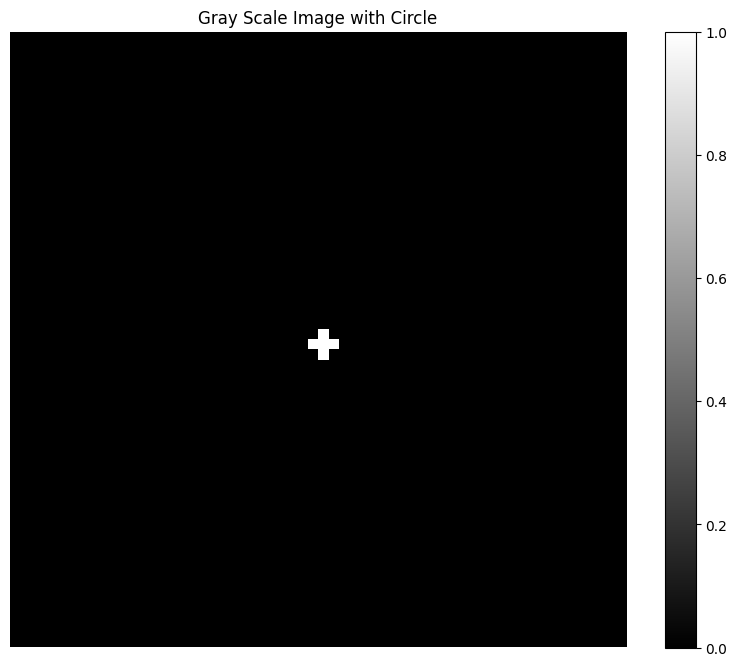

In [9]:
# plot the image
plot(image, "Gray Scale Image with Circle")

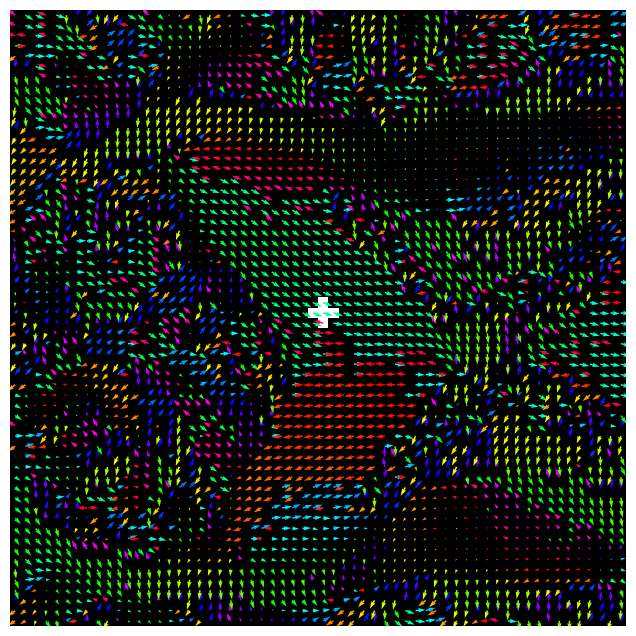

In [10]:
show_vector_field(image, eigvec_1[:, :, :2])

In [11]:
V = np.stack((eigvec_1, eigvec_2, eigvec_3), axis=-1)
Lambda = np.stack((eig_val_1, eig_val_2, eig_val_3), axis=-1)
V_scaled = V * Lambda[..., np.newaxis, :]
tensor_field = np.matmul(V_scaled, np.swapaxes(V, -1, -2))
tensor_field = tensor_field[..., :2, :2]

In [12]:
a = tensor_field[..., 0, 0]
b = tensor_field[..., 0, 1]
c = tensor_field[..., 1, 1]

We are calculating the space dependent stencil via

$$
D= \begin{bmatrix}
A & B & C \\
D & E & F \\
G & H & I
\end{bmatrix}
$$

With $A_{i,j} = \frac{1}{4} \cdot b_{i-1,j}-b_{i,j+1}$

In [13]:
a_padded = np.pad(a, pad_width=1, mode="symmetric")
b_padded = np.pad(b, pad_width=1, mode="symmetric")
c_padded = np.pad(c, pad_width=1, mode="symmetric")

In [14]:
A = (1/4) * (b_padded[0:-2, 1:-1] - b_padded[1:-1, 2:])  # b_i-1,j - b_i,j+1
B = (1/2) * (c_padded[1:-1, 2:] + c_padded[1:-1, 1:-1]) # c_i,j+1 + c_i,j
C = (1/4) * (b_padded[2:, 1:-1] + b_padded[1:-1, 2:])   # b_i+1,j + b_i,j+1
D = (1/2) * (a_padded[0:-2, 1:-1] + a_padded[1:-1, 1:-1])   # a_i-1,j + a_i,j
E = -(1/2) * (a_padded[0:-2, 1:-1] + 2*a_padded[1:-1, 1:-1] + a_padded[2:, 1:-1] + c_padded[1:-1, 0:-2] + 2 * c_padded[1:-1, 1:-1] + c_padded[1:-1, 2:])  # a_i-1,j + 2*a_i,j + a_i+1,j + c_i,j-1 + 2*c_i,j + c_i,j+1
F = (1/2) * (a_padded[2:, 1:-1] + a_padded[1:-1, 1:-1])
G = (1/4) * (b_padded[0:-2, 1:-1] + b_padded[1:-1, 0:-2])   # b_i-1,j + b_i,j-1
H = (1/2) * (c_padded[1:-1, 0:-2] + c_padded[1:-1, 1:-1])   # c_i,j-1 + c_i,j
I = (1/4) * (b_padded[2:, 1:-1] - b_padded[1:-1, 0:-2])  # b_i+1,j - b_i,j-1

Stencil = np.stack([
    np.stack([A, B, C], axis=-1),
    np.stack([D, E, F], axis=-1),
    np.stack([G, H, I], axis=-1)
], axis=-2)

In [15]:
img = image.copy()
n, m = img.shape

Id = np.zeros((3,3), dtype=np.float32)
Id[1, 1] = 1.0
w_stencil = Id + STEP_SIZE * Stencil

for i in range(ITERATIONS):
    img_padded = np.pad(img, pad_width=1, mode='symmetric')

    neighborhoods = np.lib.stride_tricks.sliding_window_view(img_padded, (3,3))

    img = np.sum(w_stencil * neighborhoods, axis=(-2, -1))

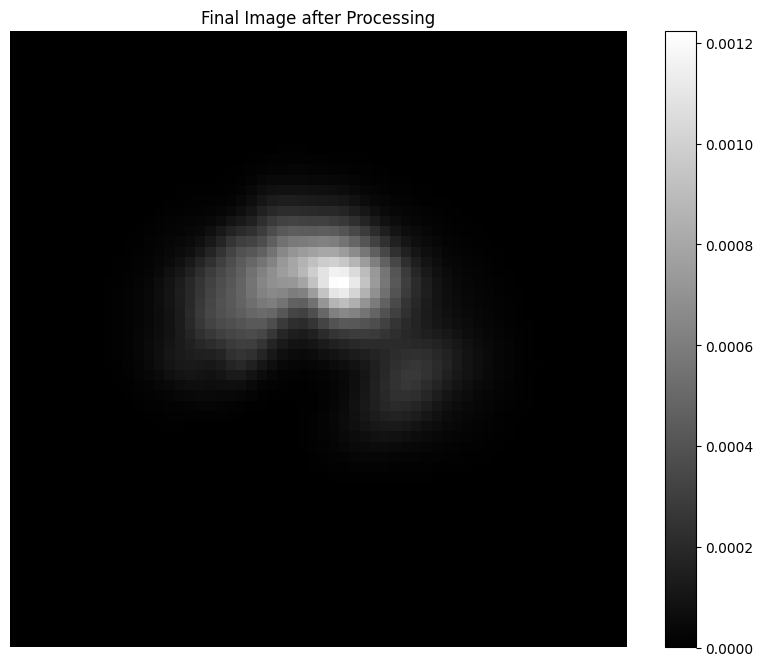

In [16]:
plot(img, title="Final Image after Processing")

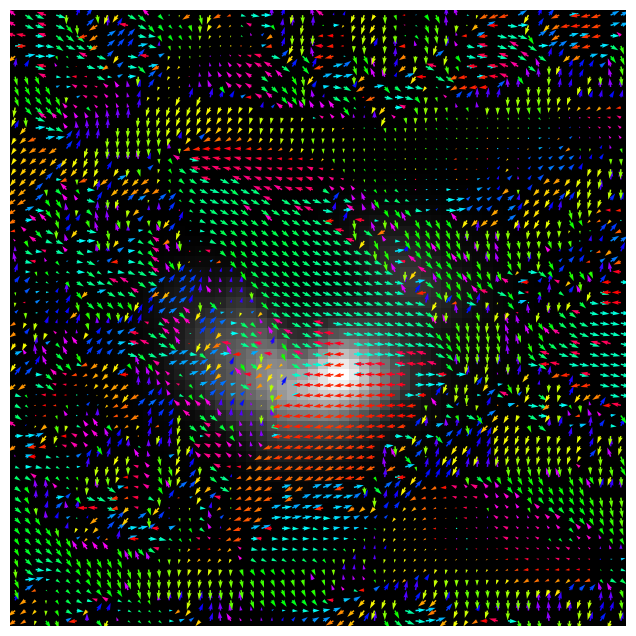

In [17]:
show_vector_field(img, eigvec_1[..., :2])

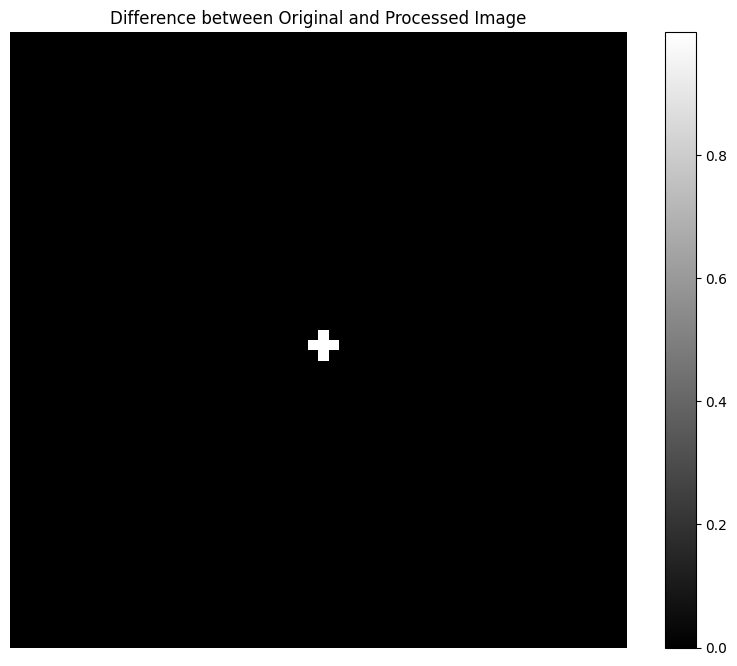

In [18]:
plot(image-img, title="Difference between Original and Processed Image")

In [19]:
# stats
np.std(image - img)

np.float64(0.03723880129001423)